In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-aapl-historical-stock-data/HistoricalQuotes.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set(rc={'figure.figsize':(15,10)})
sns.set(style="whitegrid")
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
pd.set_option('max_rows',1000)

In [3]:
df = pd.read_csv('/kaggle/input/apple-aapl-historical-stock-data/HistoricalQuotes.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [5]:
df.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23
5,02/21/2020,$313.05,32426420,$318.62,$320.45,$310.5
6,02/20/2020,$320.3,25141490,$322.63,$324.65,$318.21
7,02/19/2020,$323.62,23495990,$320,$324.57,$320
8,02/18/2020,$319,38190550,$315.36,$319.75,$314.61
9,02/14/2020,$324.95,20028450,$324.74,$325.98,$322.85


In [6]:
df["Close"] = df[' Close/Last'].str.replace('$','').astype(float)
df['Open'] = df[' Open'].str.replace('$','').astype(float)
df['High'] = df[' High'].str.replace('$','').astype(float)
df['Low'] = df[' Low'].str.replace('$','').astype(float)
df['Volume'] = df[' Volume']

drop = [' Close/Last',' Open',' High',' Low',' Volume']
df = df.drop(drop,axis=1)
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: Future

,Date,Close,Open,High,Low,Volume
0,02/28/2020,273.36,257.26,278.41,256.37,106721200
1,02/27/2020,273.52,281.10,286.00,272.96,80151380
2,02/26/2020,292.65,286.53,297.88,286.50,49678430
3,02/25/2020,288.08,300.95,302.53,286.13,57668360
4,02/24/2020,298.18,297.26,304.18,289.23,55548830


In [7]:
df['Date'].dtype

dtype('O')

In [8]:
df.describe()

,Close,Open,High,Low,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,114.769522,114.728443,115.766415,113.690582,7.258009e+07
std,60.662405,60.546893,61.134456,60.085105,5.663113e+07
min,29.835700,29.392800,29.928600,28.464300,1.136205e+07
25%,66.822475,66.877150,67.475300,66.372950,3.053026e+07
50%,101.090000,101.115000,102.085000,100.350000,5.295469e+07
75%,154.630000,154.610000,155.735000,153.325000,9.861006e+07
max,327.200000,324.740000,327.850000,323.350000,4.624423e+08


In [9]:
df["Date"] = pd.to_datetime(df["Date"],format='%m/%d/%Y')
df['Date'].head()

0   2020-02-28
1   2020-02-27
2   2020-02-26
3   2020-02-25
4   2020-02-24
Name: Date, dtype: datetime64[ns]

In [10]:
df = df.sort_values(by='Date')
df = df.reset_index(drop=True)
df.head()

,Date,Close,Open,High,Low,Volume
0,2010-03-01,29.8557,29.3928,29.9286,29.3500,137312041
1,2010-03-02,29.8357,29.9900,30.1186,29.6771,141486282
2,2010-03-03,29.9043,29.8486,29.9814,29.7057,92846488
3,2010-03-04,30.1014,29.8971,30.1314,29.8043,89591907
4,2010-03-05,31.2786,30.7057,31.3857,30.6614,224647427


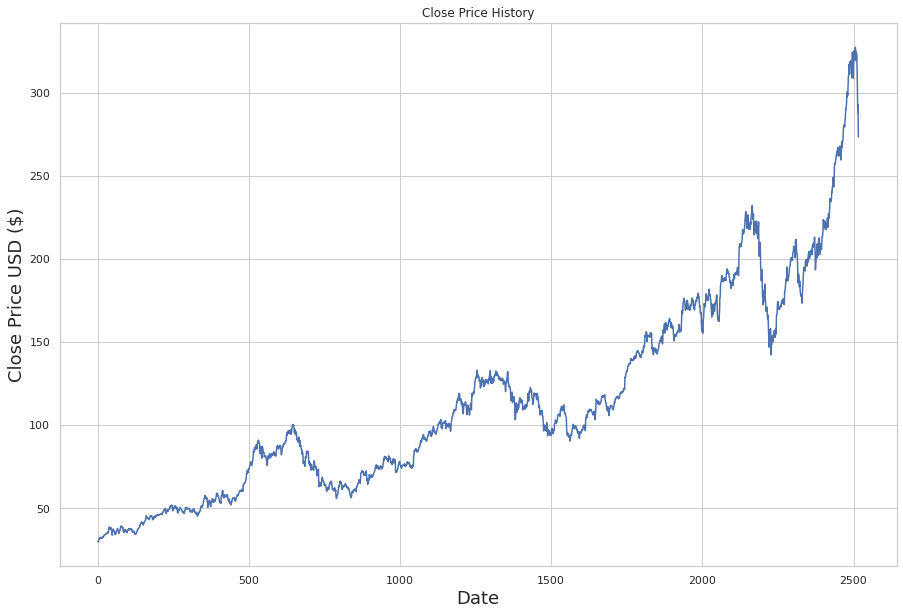

In [11]:
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [12]:
data = df.filter(['Close'])
dataset = data.values

In [13]:
training_data_len = int(np.ceil( len(dataset) * .8 ))
training_data_len

2015

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[6.72575693e-05],
       [0.00000000e+00],
       [2.30693463e-04],
       ...,
       [8.83812549e-01],
       [8.19480684e-01],
       [8.18942624e-01]])

In [15]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


[array([6.72575693e-05, 0.00000000e+00, 2.30693463e-04, 8.93516807e-04,
       4.85229733e-03, 4.91451059e-03, 6.80747487e-03, 7.68182327e-03,
       7.99894271e-03, 8.52725092e-03, 7.20126794e-03, 7.49451094e-03,
       7.33578308e-03, 7.59035298e-03, 6.43755824e-03, 7.63844214e-03,
       9.37267856e-03, 9.85794193e-03, 8.55146364e-03, 1.05930672e-02,
       1.13090240e-02, 1.29686045e-02, 1.25627051e-02, 1.30288000e-02,
       1.42394363e-02, 1.47438680e-02, 1.52530078e-02, 1.49409327e-02,
       1.58246972e-02, 1.60648067e-02, 1.61320643e-02, 1.76984931e-02,
       1.92501252e-02, 1.85197080e-02, 1.83613164e-02, 1.71698486e-02,
       2.41982646e-02, 2.76811978e-02, 2.97759348e-02, 2.91369879e-02,
       2.55531683e-02, 2.53416432e-02, 2.87236901e-02, 2.50968257e-02,
       2.76236926e-02, 2.39389866e-02, 2.26442784e-02, 1.79675233e-02,
       1.29760028e-02, 2.16858581e-02, 2.29012023e-02, 2.55770447e-02,
       2.37853031e-02, 2.16041401e-02, 2.17961605e-02, 2.09026437e-02,
     

(1955, 60, 1)

In [16]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(x_train, y_train, epochs=50)

Epoch 1/50
62/62 [==============================] - 9s 92ms/step - loss: 0.0084
Epoch 2/50
62/62 [==============================] - 6s 92ms/step - loss: 1.1254e-04
Epoch 3/50
62/62 [==============================] - 6s 92ms/step - loss: 1.1411e-04
Epoch 4/50
62/62 [==============================] - 6s 92ms/step - loss: 1.2560e-04
Epoch 5/50
62/62 [==============================] - 6s 94ms/step - loss: 1.1192e-04
Epoch 6/50
62/62 [==============================] - 6s 96ms/step - loss: 1.3525e-04
Epoch 7/50
62/62 [==============================] - 6s 93ms/step - loss: 1.0141e-04
Epoch 8/50
62/62 [==============================] - 6s 93ms/step - loss: 1.0168e-04
Epoch 9/50
62/62 [==============================] - 6s 93ms/step - loss: 1.1594e-04
Epoch 10/50
62/62 [==============================] - 6s 92ms/step - loss: 9.8885e-05
Epoch 11/50
62/62 [==============================] - 6s 96ms/step - loss: 8.1586e-05
Epoch 12/50
62/62 [==============================] - 6s 92ms/step - loss: 9.80

In [17]:

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    

x_test = np.array(x_test)


x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4.25320942314984

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


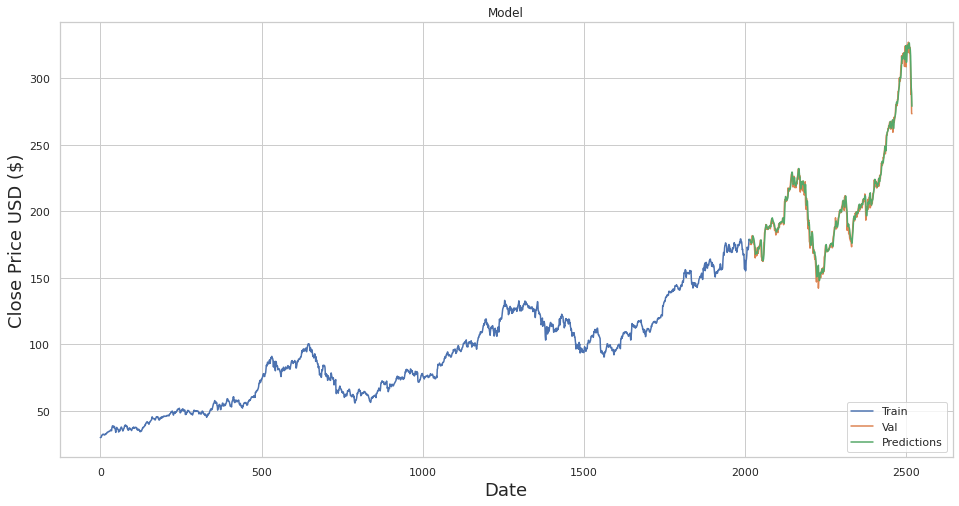

In [18]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
len(test_data)

563

In [20]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 222)

In [21]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [22]:
temp_input

[0.5684418069015009,
 0.5696524431480173,
 0.5697197007172683,
 0.5827676691519459,
 0.5852225704296043,
 0.58747569899951,
 0.59739619046402,
 0.5963200693560053,
 0.5899978578464193,
 0.5867022369531245,
 0.5877447292765137,
 0.5744949881340833,
 0.6076193409901592,
 0.6030121974964715,
 0.6117556814990904,
 0.6007590689265657,
 0.5818596919670586,
 0.5819942071055604,
 0.5746631320572106,
 0.5627585422997986,
 0.524219955119024,
 0.5341068177989086,
 0.5417069231242619,
 0.5388821052157237,
 0.5352501964761741,
 0.5153755847625286,
 0.5271792881660643,
 0.5143330924391395,
 0.5038409116359966,
 0.50152052549684,
 0.4990319954345561,
 0.4961735487413923,
 0.49926739692693445,
 0.48840529949291156,
 0.4824530046142056,
 0.5037736540667457,
 0.5135260016081284,
 0.5225385158877511,
 0.5391175067081018,
 0.5472893013720881,
 0.5547885203435651,
 0.5527035356967867,
 0.5525690205582849,
 0.5478273619260954,
 0.5516946721580229,
 0.5670293979472316,
 0.5650789284389551,
 0.570425905194403

In [23]:
valid

,Close,Predictions
2015,175.000,178.911728
2016,176.210,177.523239
2017,176.820,176.632645
2018,176.670,176.483627
2019,175.030,176.576996
2020,176.940,176.033035
2021,179.980,176.445999
2022,181.720,178.363754
2023,179.970,180.759186
2024,178.440,181.549942


In [24]:
import matplotlib.pyplot as plt

In [25]:
import matplotlib.pyplot as plt

In [26]:
len(df1)

NameError: name 'df1' is not defined